Assignment Title: Develop a Face Recognition System

Objective:

Build a face recognition system using convolutional neural networks (CNNs).
Understand the ethical implications of face recognition technologies.
Assignment Instructions:

Dataset:
Use a custom or public face dataset (e.g., LFW dataset) for training the model.
Model Implementation:
Develop a CNN-based face recognition system using the OpenCV library and TensorFlow/Keras.
Train the model to recognize faces from the dataset, and evaluate its performance.
Ethics Discussion:
Write a section in the report discussing the ethical considerations of face recognition technology, including issues of privacy, bias, and fairness.

## Import Libraries and Load Subset of Data
- Starting with subset of 15 people to experiment
- Whole Dataset is too heavy and difficult to proccess

/

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/lfw-deep-funneled



|

hub://activeloop/lfw-deep-funneled loaded successfully.



Raw name tensor: Tensor(key='name', index=Index([0]))
Name data: {'value': array([0], dtype=uint32), 'text': ['Sergio_Vieira_De_Mello']}

Available fields:
- images
- name


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/deeplake/core/tensor.py:719: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


Selected people: ['Gerhard_Schroeder', 'Donald_Rumsfeld', 'George_W_Bush', 'Tony_Blair', 'Colin_Powell', 'Ariel_Sharon', 'Hugo_Chavez']


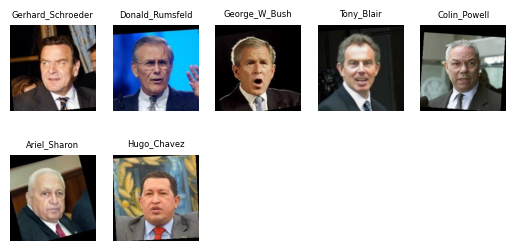

In [41]:
import deeplake
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import cv2


# Load a small subset of the LFW dataset
ds = deeplake.load('hub://activeloop/lfw-deep-funneled')

# Print data attributes
name = ds.name[0]  # Get first name
print("Raw name tensor:", name)
print("Name data:", name.data())  

# Show the available fields
print("\nAvailable fields:")
for field in ds.tensors:
    print(f"- {field}")

X = []  # Images
y = []  # Names

# Count occurrences per person
all_counts = Counter(ds.name[i].data()['text'][0] for i in range(len(ds)))

# Select people with at least 25 images
eligible_people = {name for name, count in all_counts.items() if count >= 70}

person_counts = defaultdict(int)
selected_people = set()

for i in range(len(ds)):
    name_val = ds.name[i].data()['text'][0]
    
    if name_val not in eligible_people:
        continue

    if len(selected_people) < 15:
        selected_people.add(name_val)

    if name_val in selected_people and person_counts[name_val] < 70:
        image = ds.images[i].numpy()
        
        X.append(image)
        y.append(name_val)
        person_counts[name_val] += 1

    if len(selected_people) == 15 and all(count == 70 for count in person_counts.values()):
        break


print("Selected people:", list(selected_people))
# Show one image of each person and a square of their name in their face
for i, name_val in enumerate(selected_people):
    for j in range(len(X)):
        if y[j] == name_val:
            img = X[j]
            break

    plt.subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.title(name_val, fontsize=6)
    plt.axis('off')
plt.show()


## Pre Process Data

In [42]:
# Resize and normalize images using OpenCV
def preprocess_images(image):
    image = cv2.resize(image, (64, 64))  # Resize to 64x64
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Ensure correct color format
    image = image / 255.0  # Normalize to [0,1]
    return image

# Apply preprocessing to all images
X = np.array([preprocess_images(img) for img in X])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Print dataset shapes
print("X shape:", X.shape)
print("y shape:", y.shape)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


# Split the dataset
from sklearn.utils import shuffle
X, y_encoded = shuffle(X, y_encoded, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

X shape: (490, 64, 64, 3)
y shape: (490,)


## Define & Train the Model

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1584 - loss: 2.9678WARNING:tensorflow:5 out of the last 16 calls to <function TensorFlowTrainer.make_test_function.<locals>.one_step_on_iterator at 0x3772d1b20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.1562 - loss: 2.9272 - val_accuracy: 0.2785 - val_loss: 1.9448
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.1604 - loss: 1.9463 - val

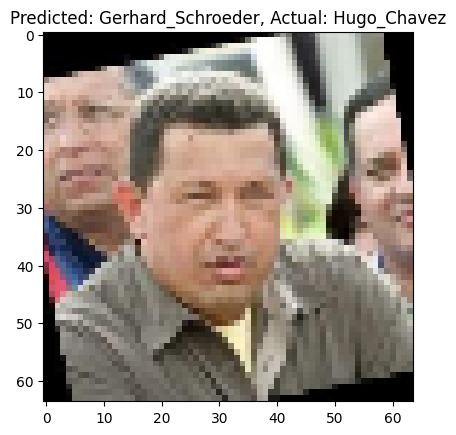

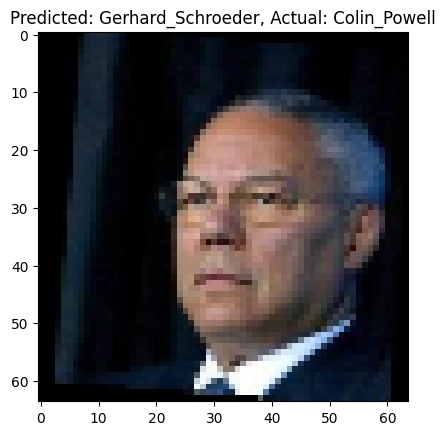

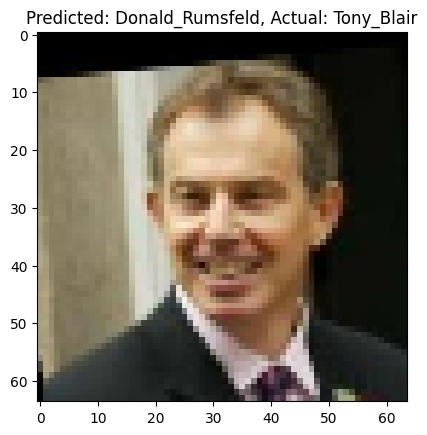

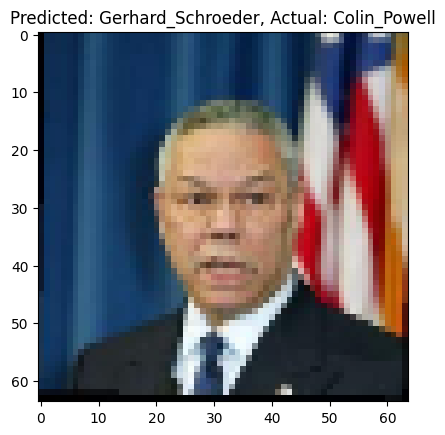

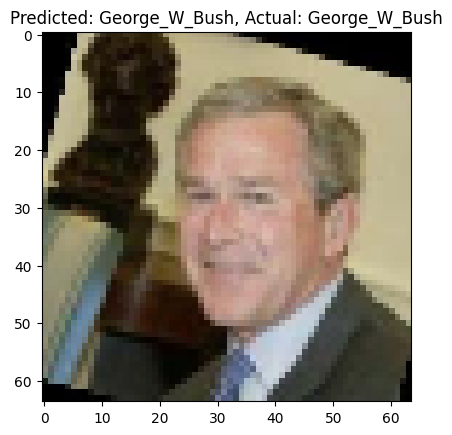

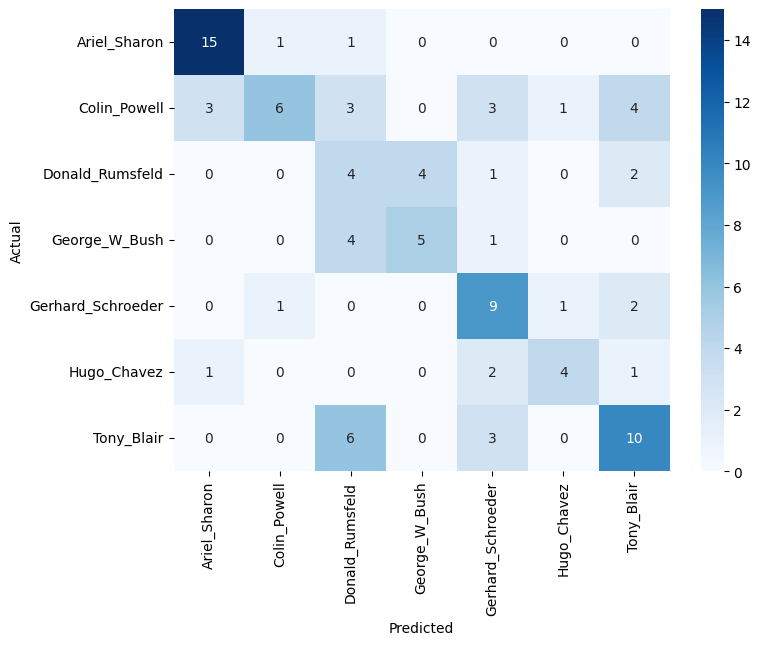

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras import models, layers
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = models.Sequential([
    Input(shape=(64, 64, 3)),  # Define input layer explicitly
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer

    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout before the final dense layer
    Dense(len(selected_people), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

# Save the model using the native Keras format:
model.save('face_recognition_model.keras')

# Load the model
loaded_model = tf.keras.models.load_model('face_recognition_model.keras')

# Predict using the loaded model
predictions = loaded_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Visualize some predictions
for i in range(5):
    # Convert image from float32 (normalized) back to uint8 (0-255 range)
    img = (X_test[i] * 255).astype(np.uint8)

    # Convert BGR to RGB if needed
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.title(f"Predicted: {label_encoder.inverse_transform([predicted_labels[i]])[0]}, Actual: {label_encoder.inverse_transform([y_test[i]])[0]}")
    plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Test with image not in dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted: ['Hugo_Chavez']


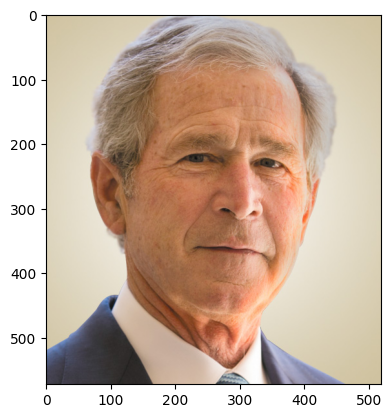

In [44]:
## Test with other images
path = "Bush.jpg"
plt.imshow(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))

img = cv2.imread(path)
img = cv2.resize(img, (64, 64))
img = img / 255.0
img = np.expand_dims(img, axis=0)
pred = loaded_model.predict(img)
print("Predicted:", label_encoder.inverse_transform([np.argmax(pred)]))

## Analysis of Results
Currently, the model achieves an accuracy between 55-70%, which suggests that while it is learning, there is room for improvement. Some potential factors affecting performance include:
- Dataset Size & Class Imbalance: Using only 15 people with 70 images each limits the model’s generalization.
- Data Preprocessing Issues: Possible inconsistencies in image scaling and color normalization.
- Overfitting: The model may be overfitting due to a relatively small dataset.
- Hyperparameter Selection: The choice of optimizer, learning rate, batch size, and dropout rates could be further optimized.

## Implementing Data Augmentation